In [2]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [3]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [4]:
#Set the parameters
#left side of tube
rho_L = 1.0 #kg/m3
vel_L = 0.0 #m/s
P_L = 100000 #kN/m3
#right side of tube
rho_R = 0.125 #kg/m3
vel_R = 0.0 #m/s
P_R = 10000 #kN/m3

#nx = 200
#dx = 0.1
#Considering initial wave speed of 374.17 m/s
#dt = 0.3*0.1/374.17
#nt = 200

nx = 81
dx = 0.25
dt = 0.0002
gamma = 1.4
nt = 100


nt_req = 0.01/dt
print(dx, dt, nx, nt, nt_req)
 

x = numpy.linspace(-10.0, 10.0, num = nx)

0.25 0.0002 81 100 50.0


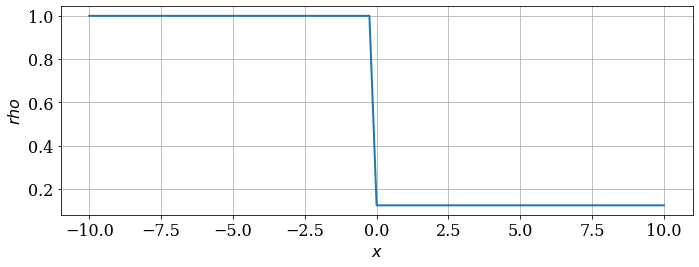

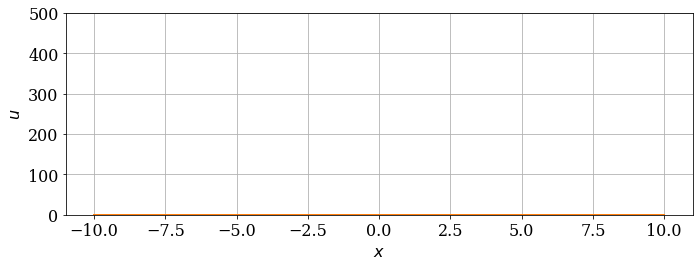

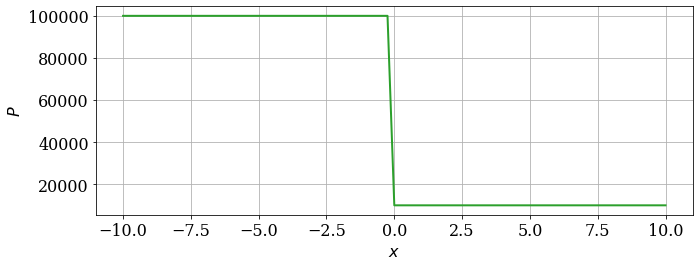

In [5]:
#Initial condition

rho0 = rho_L*numpy.ones_like(x)
mask = numpy.where(x>=0)
rho0[mask] = rho_R

u0 = vel_L*numpy.ones_like(x)
u0[mask] = vel_R

P0 = P_L*numpy.ones_like(x)
P0[mask] = P_R

#Plotting initial condition of rho
fig_rho = pyplot.figure(figsize=(10.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$rho$')
pyplot.grid()
line_rho = pyplot.plot(x, rho0,
                   color='C0', linestyle='-', linewidth=2)[0]
#pyplot.xlim(0.0, L)
#pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()

#Plotting initial condition of u
fig_u = pyplot.figure(figsize=(10.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$u$')
pyplot.grid()
line_u = pyplot.plot(x, u0, 
                    color = 'C1', linestyle = '-', linewidth = 2)[0]
#pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 500)
pyplot.tight_layout()

#Plotting initial condition of P
fig_P = pyplot.figure(figsize=(10.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$P$')
pyplot.grid()
line_P = pyplot.plot(x, P0, 
                    color = 'C2', linestyle = '-', linewidth = 2)[0]
#pyplot.xlim(0.0, L)
#pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()

In [6]:
def e_T(P, rho, u):
    
    """
    Calculates the specific total energy of the fluid
    
    P = 1D numpy array, Pressure values at all x locations at a time instant
    rho = 1D numpy array, density values at all x locations at a time instant
    u = 1D numpy array, velocity values at all x locations at a time instant
    --------
    returns: 
    e_T = 1D numpy array, specific internal energy values at all x locations at a time instant
    
    """
    
    gamma = 1.4 #gas constant at ideal condition
    e_T = (1/rho)*((P/(gamma -1)) + 0.5*(rho*(u**2)))
    
    return e_T

In [7]:
#e_T0 = e_T(P0, rho0, u0)
#print(e_T0)

In [8]:
def U_vector(rho, u, P):
    
    """
    Creates the array u_bar
    
    P = 1D numpy array, Pressure values at all x locations at a time instant
    rho = 1D numpy array, density values at all x locations at a time instant
    u = 1D numpy array, velocity values at all x locations at a time instant
    --------
    returns:
    U = 2D numpy array, u_bar values at all x loactions at a time instant
    
    """
    U = numpy.array([rho,
                    rho*u,
                    rho*e_T(P, rho, u)])
    
    return U

In [9]:
U0 = U_vector(rho0, u0, P0)
print(numpy.shape(U0))
#print(numpy.shape(U0[2]), U0, "\n", U0[2])

(3, 81)


In [10]:
def flux(U):
    
    """
    Calculates the flux based on u_bar array
    
    U = 2D numpy array, u_bar values at all x loactions at a time instant
    ------
    returns: 
    F = 2D numpy array, f_bar values at all x locations at a time instant
    """
    
    F = numpy.array([U[1],
                    ((U[1]**2)/U[0]) + (0.4 * (U[2] - 0.5*((U[1]**2)/U[0]))),
                    (U[2] + 0.4 * (U[2] - (0.5* (U[1]**2/U[0])))) * (U[1]/U[0])])
    return F

In [11]:
F0 = flux(U0)
print( numpy.shape(F0[:, 1:]))

(3, 80)


In [12]:
#implementing the Richtmeyr scheme
def richtmyer(U0, nt, dt, dx):


    U_hist = [U0.copy()]
    U = U0.copy()
    U_star = U.copy() #here U_star = U(n+1/2) values

    for n in range(nt):
    
        F = flux(U)
        U_star[:,1:] = 0.5*(U[:,1:] + U[:,:-1]) - (dt/(2*dx))*(F[:,1:] - F[:,:-1])
        #print(U_star)
        F = flux(U_star)
        #print(F)
        U[:,:-1] = U[:,:-1] - (dt/dx)*(F[:,1:] - F[:,:-1])
        #U[:, 0] = U[:, 1]
        #U[:, -1] = U[:, -2]
    
        U_hist.append(U.copy())
    
    return U_hist


In [13]:
def maccormack(U0, nt, dt, dx, bc_values):
    
    U_hist = [U0.copy()]
    U = U0.copy()
    U_star = U.copy() #here U_star = U(n+1/2) values
    for n in range(nt):
        # Compute the flux.
        F = flux(U)
        # Predictor step of the MacCormack scheme.
        U_star[:,1:-1] = (U[:,1:-1] - dt / dx * (F[:,1:-1] - F[:,:-2]))
        # Set the value at the first location.
        U_star[:,0] = bc_values[0]
        # Set the value at the last location.
        U_star[:,-1] = bc_values[1]
        # Compute the flux.
        F = flux(U_star)
        # Corrector step of the MacCormack scheme.
        U[:,1:-1] = 0.5 * (U[:,1:-1] + U_star[:,1:-1] - dt / dx * (F[:,2:] - F[:,1:-1]))
        # Set the value at the first location.
        U[:,0] = bc_values[0]
        # Set the value at the last location.
        U[:,-1] = bc_values[1]
        # Record the time-step solution.
        U_hist.append(U.copy())
    return U_hist

In [14]:
U_hist_1 = richtmyer(U0, nt, dt, dx)
#print(U_hist_1)

U_hist_2 = maccormack(U0, nt, dt, dx, (U0[:,0], U0[:,-1]))
print(U_hist_2[:5])

[array([[1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
        1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
        1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
        1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
        1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
        1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
        1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.25e-01, 1.25e-01,
        1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01,
        1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01,
        1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01,
        1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01,
        1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01,
        1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01, 1.25e-01,
        1.25e-01, 1.25e-01, 1.25e-01],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        

<ipython-input-10-4c6dcf2e4fd2>:13: RuntimeWarning: overflow encountered in square
  ((U[1]**2)/U[0]) + (0.4 * (U[2] - 0.5*((U[1]**2)/U[0]))),
<ipython-input-10-4c6dcf2e4fd2>:13: RuntimeWarning: invalid value encountered in add
  ((U[1]**2)/U[0]) + (0.4 * (U[2] - 0.5*((U[1]**2)/U[0]))),
<ipython-input-10-4c6dcf2e4fd2>:14: RuntimeWarning: overflow encountered in square
  (U[2] + 0.4 * (U[2] - (0.5* (U[1]**2/U[0])))) * (U[1]/U[0])])
<ipython-input-13-f8bc305f142f>:18: RuntimeWarning: invalid value encountered in subtract
  U[:,1:-1] = 0.5 * (U[:,1:-1] + U_star[:,1:-1] - dt / dx * (F[:,2:] - F[:,1:-1]))
<ipython-input-13-f8bc305f142f>:10: RuntimeWarning: invalid value encountered in subtract
  U_star[:,1:-1] = (U[:,1:-1] - dt / dx * (F[:,1:-1] - F[:,:-2]))


In [15]:
from matplotlib import animation
from IPython.display import HTML

In [16]:
def update_plot(n, U_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    """
    #updating rho values on plot
    fig_rho.suptitle('Time step {:0>2}'.format(n))
    line_rho.set_ydata(U_hist[n][0,:])
    #updating u values on plot
    fig_u.suptitle('Time step {:0>2}'.format(n))
    line_u.set_ydata(U_hist[n][1,:]/U_hist[n][0,:])
    #updating P values on plot
    fig_P.suptitle('Time step {:0>2}'.format(n))
    line_P.set_ydata(0.4*(U_hist[n][2,:] - 0.5*((U_hist[n][1,:]**2)/U_hist[n][0,:])))

In [17]:
# Create an animation of the density in shock tube.
anim = animation.FuncAnimation(fig_rho, update_plot,
                               frames=nt, fargs=(U_hist_1,),
                               interval=50)

# Display the video.
HTML(anim.to_html5_video())

In [18]:
# Create an animation of the velocity in shock tube.
anim = animation.FuncAnimation(fig_u, update_plot,
                               frames=nt, fargs=(U_hist_1,),
                               interval=50)
# Display the video
HTML(anim.to_html5_video())

In [19]:
# Create an animation of the pressure in shock tube.
anim = animation.FuncAnimation(fig_P, update_plot,
                               frames=nt, fargs=(U_hist_1,),
                               interval=50)
# Display the video
HTML(anim.to_html5_video())

In [20]:
u_values_2 = U_hist_2[50][1,:]/U_hist_2[50][0,:]
P_values_2 = 0.4*(U_hist_2[50][2,:] - 0.5*((U_hist_2[50][1,:]**2)/U_hist_2[50][0,:]))

u_values_1 = U_hist_1[50][1,:]/U_hist_1[50][0,:]
P_values_1 = 0.4*(U_hist_1[50][2,:] - 0.5*((U_hist_1[50][1,:]**2)/U_hist_1[50][0,:]))

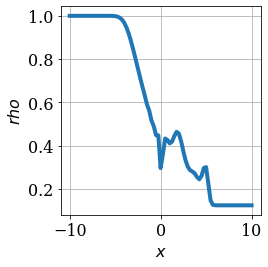

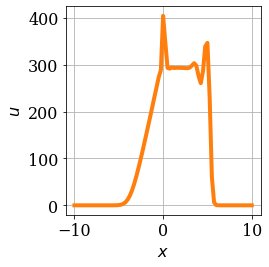

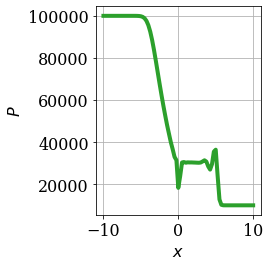

In [21]:
#Plotting initial condition of rho
fig_rho_2 = pyplot.figure(figsize=(4.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$rho$')
pyplot.grid()
line_rho_2 = pyplot.plot(x, U_hist_1[50][0,:],
                   color='C0', linestyle='-', linewidth=4)[0]
#line_rho_1 = pyplot.plot(x, U_hist_1[23][0,:],
                   #color='C5', linestyle='-', linewidth=2)[0]
#pyplot.xlim(0.0, L)
#pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()
#Plotting initial condition of u
fig_u_2 = pyplot.figure(figsize=(4.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$u$')
pyplot.grid()
line_u_2 = pyplot.plot(x, u_values_1, 
                    color = 'C1', linestyle = '-', linewidth = 4)[0]
#pyplot.xlim(0.0, L)
#pyplot.ylim(0.0, 150.0)
pyplot.tight_layout()

#Plotting initial condition of P
fig_P_2 = pyplot.figure(figsize=(4.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$P$')
pyplot.grid()
line_P_2 = pyplot.plot(x, P_values_1, 
                    color = 'C2', linestyle = '-', linewidth = 4)[0]
#pyplot.xlim(0.0, L)
#pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()

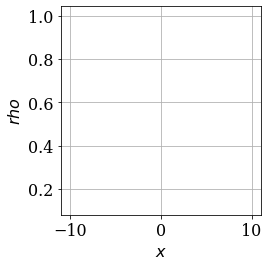

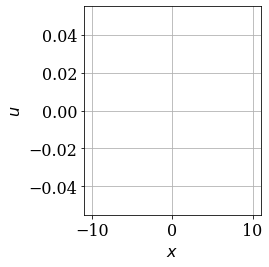

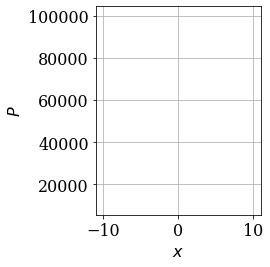

In [22]:
#Plotting initial condition of rho
fig_rho_2 = pyplot.figure(figsize=(4.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$rho$')
pyplot.grid()
line_rho_2 = pyplot.plot(x, U_hist_2[50][0,:],
                   color='C0', linestyle='-', linewidth=4)[0]
#line_rho_1 = pyplot.plot(x, U_hist_1[23][0,:],
                   #color='C5', linestyle='-', linewidth=2)[0]
#pyplot.xlim(0.0, L)
#pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()
#Plotting initial condition of u
fig_u_2 = pyplot.figure(figsize=(4.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$u$')
pyplot.grid()
line_u_2 = pyplot.plot(x, u_values_2, 
                    color = 'C1', linestyle = '-', linewidth = 4)[0]
#pyplot.xlim(0.0, L)
#pyplot.ylim(0.0, 150.0)
pyplot.tight_layout()

#Plotting initial condition of P
fig_P_2 = pyplot.figure(figsize=(4.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$P$')
pyplot.grid()
line_P_2 = pyplot.plot(x, P_values_2, 
                    color = 'C2', linestyle = '-', linewidth = 4)[0]
#pyplot.xlim(0.0, L)
#pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()

In [23]:
x_req = numpy.where(x == 2.5)
print(x_req)

(array([50], dtype=int64),)


In [24]:
rho_ans_1 = U_hist_1[50][0,50]
u_ans_1 = U_hist_1[50][1,50]/U_hist_1[50][0,50]
P_ans_1 = 0.4*(U_hist_1[50][2,50] - 0.5*((U_hist_1[50][1,50]**2)/U_hist_1[50][0,50]))

print(rho_ans_1, u_ans_1, P_ans_1)

0.3746914026476011 292.61147152682673 30250.89016757202


### The below implementation of MUSCL method for Sods Shock Tube is wrong. The meaning of nx and thus the indexing of arrays changes, as nx in MUSCL means the no of cells and not the grid points. 

In [25]:
print(numpy.shape(U0))
for i in range(1, len(U0) - 1):
    dU0_minus = (U0[i] - U0[i-1])/dx
    
print(numpy.shape(dU0_minus))

(3, 81)
(81,)


In [26]:
def minmod(U, dx):
    
    sigma = numpy.zeros_like(U)
    for i in range(1, len(U) - 1): 
        # 1 to len(U) - 1 because i=1 amd i-1 = 0. If i=0, the we cannot find i-1. Hence start with i = 1
        dU_minus = (U[i] - U[i-1])/dx
        dU_plus = (U[i+1] - U[i])/dx
        
        #implementing minmod
        if dU_minus[i] > 0 and dU_plus[i] > 0:
            sigma[i] = min(dU_minus[i], dU_plus[i])
        elif dU_minus[i] < 0 and dU_plus[i] < 0:
            sigma[i] = max(dU_minus[i], dU_plus[i])
        else:
            sigma[i] = 0.0
    return sigma

In [27]:
numpy.shape(U0)

(3, 81)

In [28]:
#trial for minmod function
sigma_values0 = minmod(U0, dx)
print(numpy.shape(sigma_values0))

(3, 81)


In [29]:
def muscl_flux(U):
    
    sigma = minmod(U, dx)
    
    U_L = (U + sigma * dx / 2.0)[:,:-1]
    U_R = (U + sigma * dx / 2.0)[:,1:]
    #print(numpy.shape(U_L))
    muscl_F = 0.5 * (flux(U_L) + flux(U_R) - (dx/dt)*(U_R - U_L))
    
    return muscl_F

In [30]:
muscl_F_0 = muscl_flux(U0)
print(numpy.shape(muscl_F_0))

(3, 80)


In [31]:
def muscl(U0, nt, dt, dx, bc_values):
    
    U_hist = [U0.copy()]
    U = U0.copy()
    U_star = U.copy()
    
    for n in range(nt): 
        #Compute flux at all cell boundaries
        F = muscl_flux(U)
        #Perform 1st step of RK2
        U_star[:, 1:-1] = U[:, 1:-1] - dt/dx*(F[:, 1:] - F[:, :-1])
        #Apply boundary conditions
        U_star[:, 0], U_star[:, -1] = bc_values
        #Compute the flux at cell boundaries based on U_star
        F = muscl_flux(U_star)
        #Perform 2nd step of RK2
        U[:,1:-1] = 0.5*(U[:,1:-1] + U_star[:,1:-1] - dt/dx*(F[:,1:] - F[:,:-1]))
        #Apply boundary conditions
        U[:,0], U[:,-1] = bc_values
        #Record the time-step solution
        U_hist.append(U.copy())
    return U_hist 

In [32]:
U_hist_3 = muscl(U0, nt, dt, dx, (U0[:,0], U0[:,-1]))
print(numpy.shape(U_hist_3))

(101, 3, 81)


In [33]:
# Create an animation of the density in shock tube.
anim = animation.FuncAnimation(fig_rho, update_plot,
                               frames=nt, fargs=(U_hist_3,),
                               interval=100)

# Display the video.
HTML(anim.to_html5_video())

In [34]:
# Create an animation of the velocity in shock tube.
anim = animation.FuncAnimation(fig_u, update_plot,
                               frames=nt, fargs=(U_hist_3,),
                               interval=100)
# Display the video
HTML(anim.to_html5_video())

In [35]:
# Create an animation of the pressure in shock tube.
anim = animation.FuncAnimation(fig_P, update_plot,
                               frames=nt, fargs=(U_hist_3,),
                               interval=100)
# Display the video
HTML(anim.to_html5_video())

In [36]:
u_values_3 = U_hist_3[23][1,:]/U_hist_3[23][0,:]
P_values_3 = 0.4*(U_hist_3[23][2,:] - 0.5*((U_hist_3[23][1,:]**2)/U_hist_3[23][0,:]))

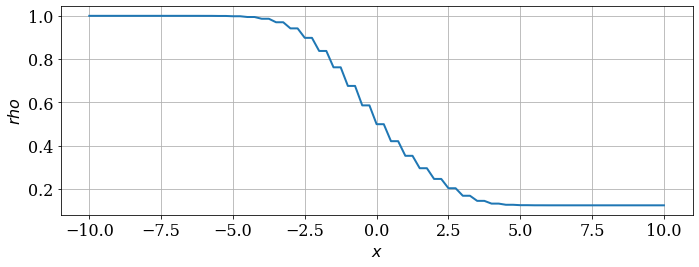

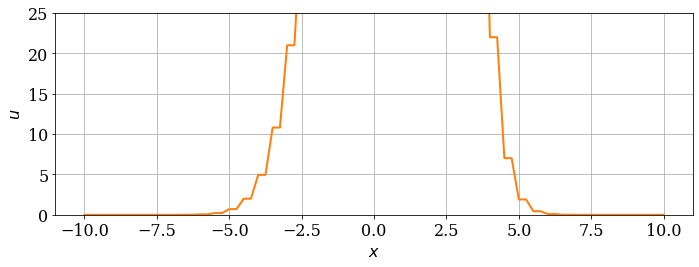

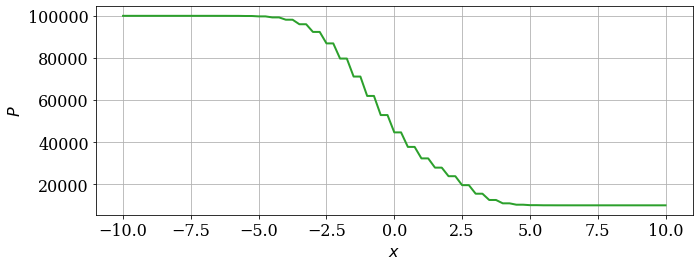

In [37]:
#Plotting initial condition of rho
fig_rho_3 = pyplot.figure(figsize=(10.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$rho$')
pyplot.grid()
line_rho_3 = pyplot.plot(x, U_hist_3[23][0,:],
                   color='C0', linestyle='-', linewidth=2)[0]
#pyplot.xlim(0.0, L)
#pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()
#Plotting initial condition of u
fig_u_3 = pyplot.figure(figsize=(10.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$u$')
pyplot.grid()
line_u_3 = pyplot.plot(x, u_values_3, 
                    color = 'C1', linestyle = '-', linewidth = 2)[0]
#pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 25.0)
pyplot.tight_layout()

#Plotting initial condition of P
fig_P_3 = pyplot.figure(figsize=(10.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$P$')
pyplot.grid()
line_P_3 = pyplot.plot(x, P_values_3, 
                    color = 'C2', linestyle = '-', linewidth = 2)[0]
#pyplot.xlim(0.0, L)
#pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()